In [1]:
import os
import json

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Get test results

TEST_ROOT = "./results/metrics"
FIGS_ROOT = "./results/figs"

MODEL_NAME_STD2READABLE = {
    "A10": "Train on Original",
    "A11": "Train on Uniform Noise",
    "A12": r"Train on Rotated 90$\degree$",
    "A13": "Train on Ring Artifact",
    "C11": r"Train on all but Rotated 90$\degree$",
    "C10": "Train on all but Ring Artifact",
    "D20": r"DANN ($\mathcal{S}=\text{Original}, \mathcal{T}=\text{Rotated 90}\degree$)", # manually transcribed from Sam's screenshots
    "D21": r"DANN ($\mathcal{S}=\text{Original}, \mathcal{T}=\text{Ring Artifact}$)", # manually transcribed from Sam's screenshots
}

METRIC_NAME_COL2READABLE = {
    # "eval_loss": "Test Loss",
    "eval_accuracy_branch1": "Test Accuracy (Labels)",
    "eval_precision_branch1": "Test Macro Precision (Labels)",
    "eval_recall_branch1": "Test Macro Recall (Labels)",
    "eval_f1_branch1": "Test Macro F1 (Labels)",
    # "eval_accuracy_branch2": "Test Accuracy (Domain)",
    # "eval_precision_branch2": "Test Macro Precision (Domain)",
    # "eval_recall_branch2": "Test Macro Recall (Domain)",
    # "eval_f1_branch2": "Test Macro F1 (Domain)",
}

TESTSET_NAME_GIVEN2PUBLISHED = {
    # "Undistorted Test Set": "Original",
    # "Uniform Test Set": "Uniform Noise",
    # "Rotate Test Set": "Rotate 90 deg.",
    # "Ring Artifact Test Set": "Ring Artifact",
    # "All Distortions Test Set": "UNUSED 1",
    # "Uniform and Rotate Test Set": "UNUSED 2",
    "undistorted": "Original",
    "uniform": "Uniform Noise",
    "rotate": "Rotate Test Set",
    "ring_artifact": "Ring Artifact",
}

MODEL_NAMES_STD = list(MODEL_NAME_STD2READABLE.keys())
METRIC_NAMES_COL = list(METRIC_NAME_COL2READABLE.keys())

FONTSIZE_L=23
FONTSIZE_S=18


In [2]:
# Reformat the D experiments
def csv_allfolds_to_eachfold(allfold_csv_fp: str, eachfold_csv_root: str):
    """Reformat a csv containing all k folds to k separate csv's in the expected format"""

    df = pd.read_csv(allfold_csv_fp)

    df[["Fold", "Dataset"]] = df["Dataset"].str.extract(r"(Fold_\d+)_(.*)")
    
    # Split and save CSVs
    for fold, subset in df.groupby("Fold"):
        subset.to_csv(os.path.join(eachfold_csv_root, f"{fold}.csv"), index=False)

fp_allfold_to_eachfold = {
    "D20_allfolds/D20_cv_test_metrics_v2.csv": "D20/",
    "D21_allfolds/D21_cv_test_metrics_v2.csv": "D21/",
}

for allfold_csv_fp, eachfold_csv_root in fp_allfold_to_eachfold.items():
    csv_allfolds_to_eachfold(
        os.path.join(TEST_ROOT, allfold_csv_fp),
        os.path.join(TEST_ROOT, eachfold_csv_root),
    )

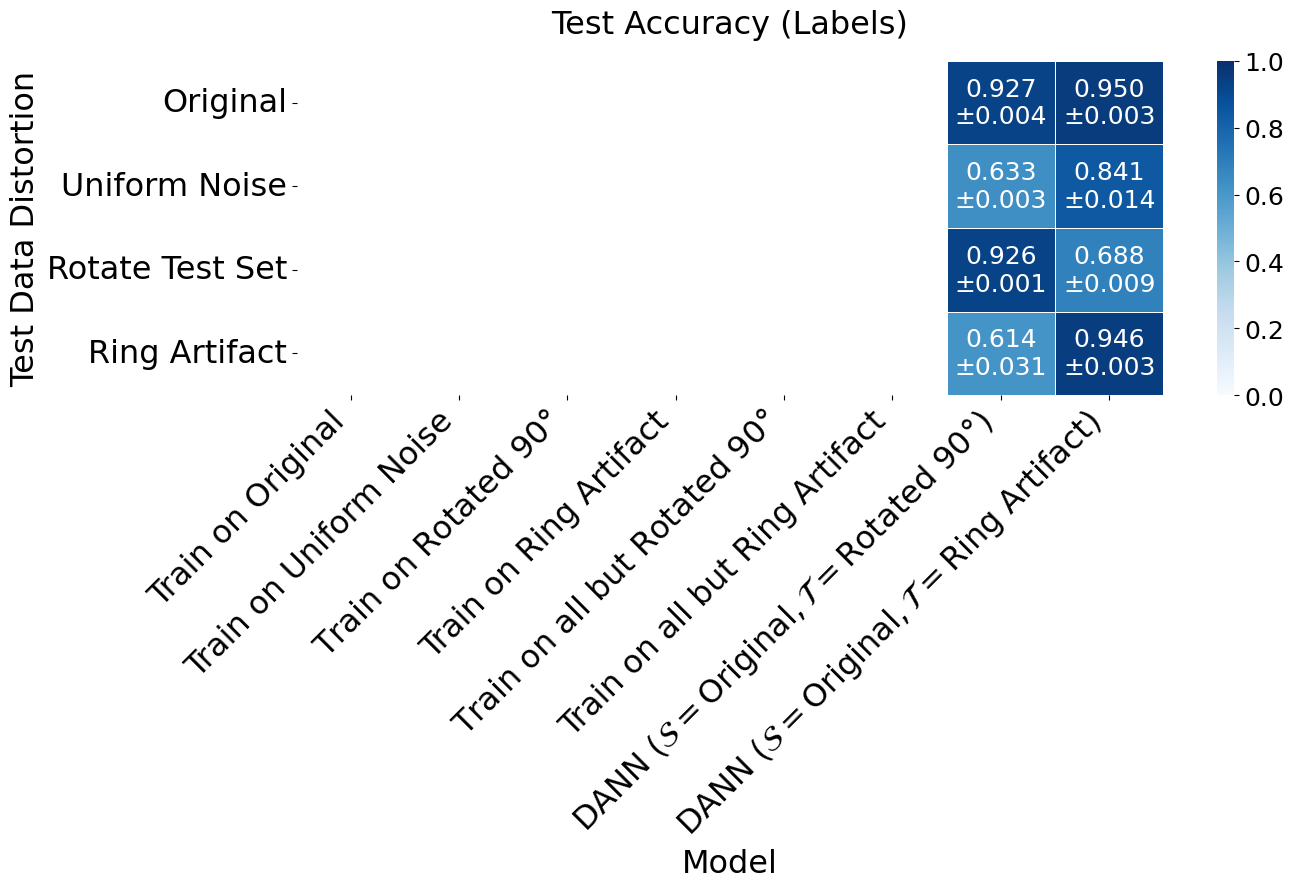

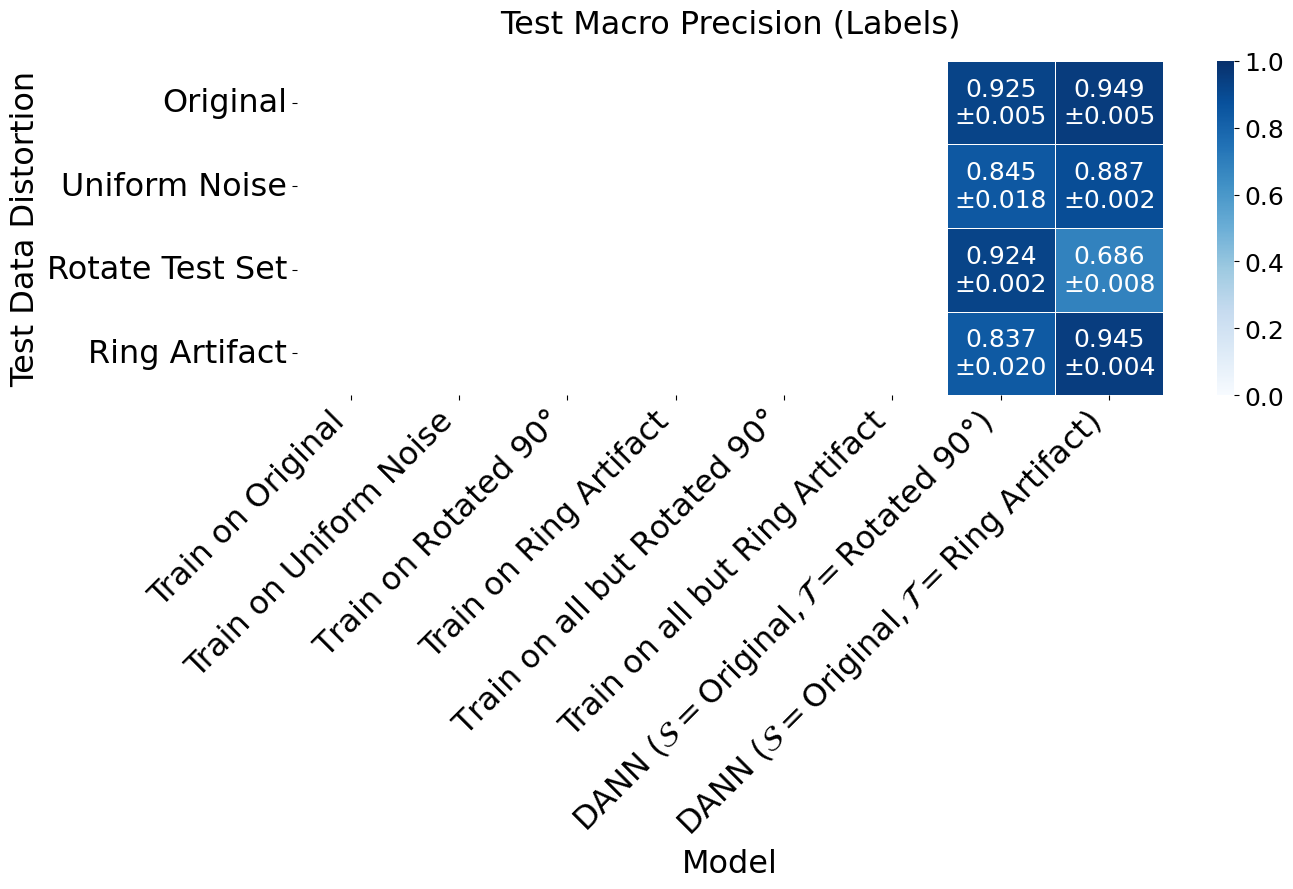

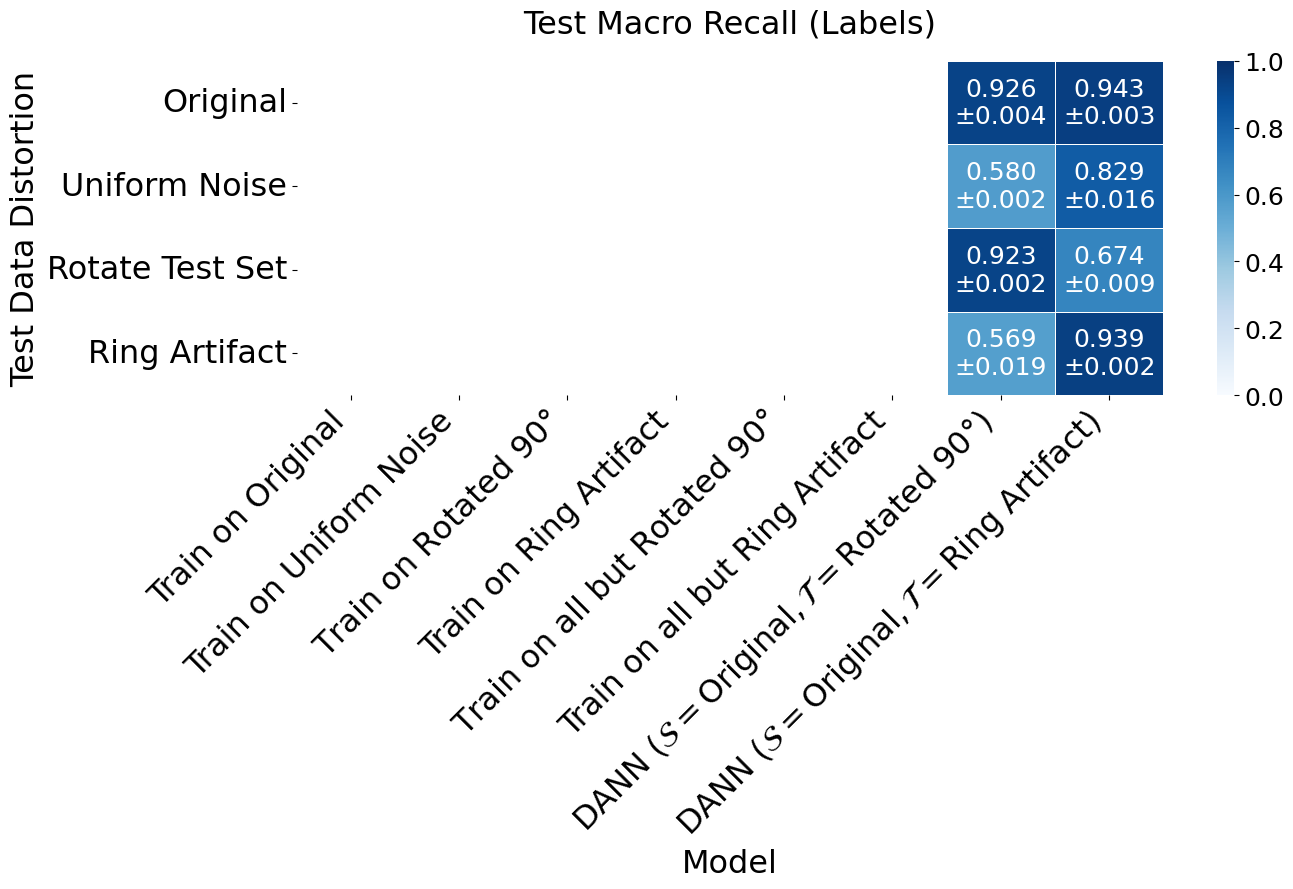

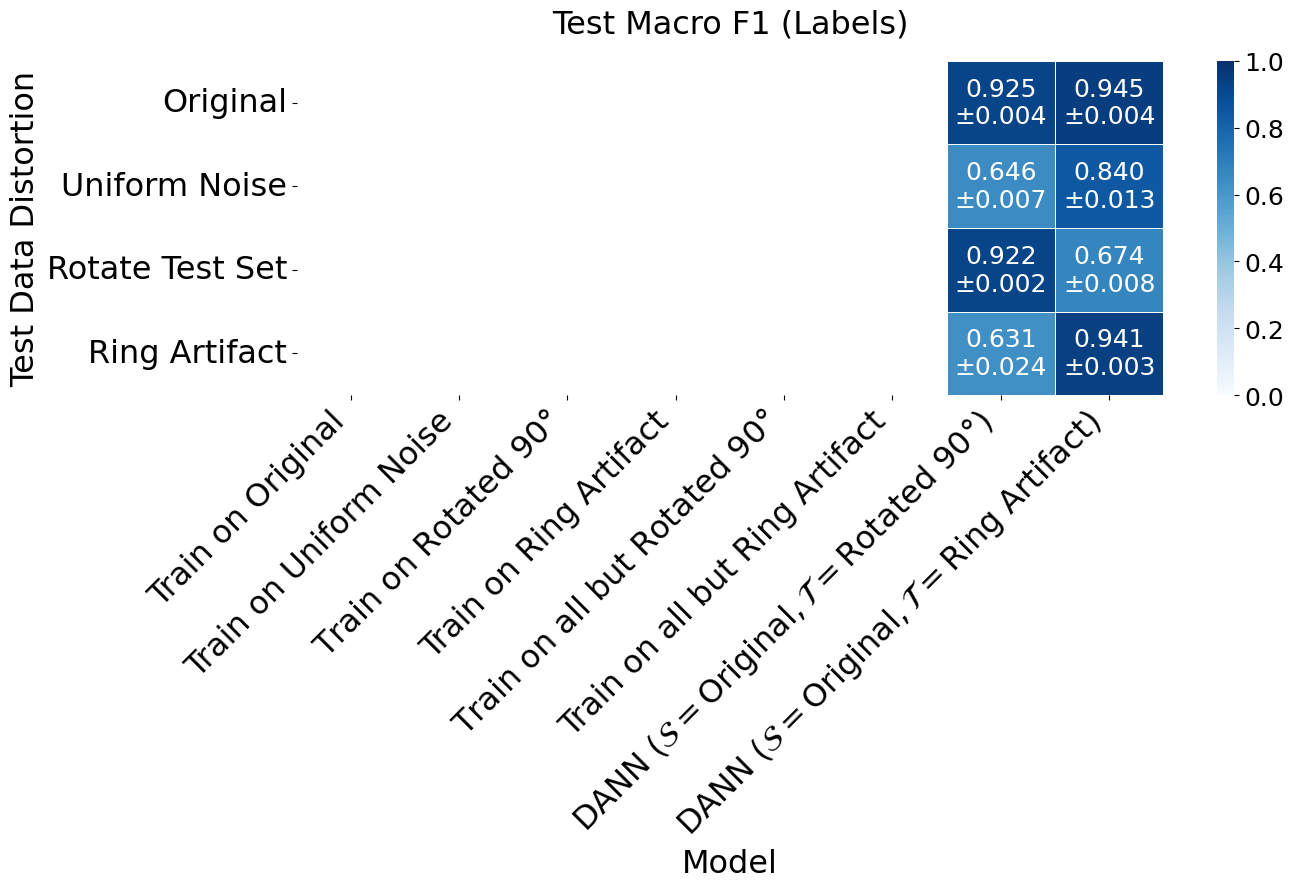

In [3]:

def mean_std_dfs_to_heatmap(mean_df, std_df, ttl, vmin=0, vmax=1, figsize=None):
    if figsize==None:
        figsize=(10,6)

    plusminus_df = mean_df.map(lambda m: f"{m:.3f}") + "\n±" + std_df.map(lambda s: f"{s:.3f}")
    
    # Plot heatmap
    plt.figure(figsize=figsize)
    ax = sns.heatmap(
        mean_df,
        cmap="Blues",
        annot=plusminus_df,
        fmt="", # Keep format from above
        linewidths=0.5,
        vmin=vmin,
        vmax=vmax,
        annot_kws={"size": FONTSIZE_S}
    )
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=FONTSIZE_S)

    plt.title(ttl, pad=20, fontsize=FONTSIZE_L)
    plt.xlabel("Model", fontsize=FONTSIZE_L)
    plt.ylabel("Test Data Distortion", fontsize=FONTSIZE_L)
    plt.xticks(rotation=45, ha='right', fontsize=FONTSIZE_L)
    plt.yticks(rotation=0, fontsize=FONTSIZE_L)
    plt.tight_layout()
    plt.savefig(os.path.join(FIGS_ROOT, ttl + ".png"))
    plt.show()

def create_kfold_test_matrices(figsize: tuple[int, int]):
    
    # Collect all relevant metrics from files
    metric_tables = {}
    for stat in ["mean", "std"]:
        metric_tables[stat] = {}
        for metric_name_col in METRIC_NAMES_COL:
            metric_name_readable = METRIC_NAME_COL2READABLE[metric_name_col]
            metric_tables[stat][metric_name_readable] = {}
            for model_name_std in MODEL_NAMES_STD:
                fold_test_result_fps = [os.path.join(TEST_ROOT,model_name_std,x) for x in os.listdir(os.path.join(TEST_ROOT,model_name_std)) if ".csv" in x]

                fold_metrics = {}
                for fold_num in range(len(fold_test_result_fps)):
                    fold_test_result_fp = fold_test_result_fps[fold_num]
                    df = pd.read_csv(fold_test_result_fp, index_col="Dataset")
                    if metric_name_col in df.columns:
                        fold_metrics[fold_num] = df[metric_name_col]
        
                df = pd.DataFrame(fold_metrics)
                if stat == "mean":
                    metric_tables[stat][metric_name_readable][model_name_std] = df.mean(axis=1)
                elif stat == "std":
                    metric_tables[stat][metric_name_readable][model_name_std] = df.std(axis=1)
                else:
                    assert False

    dfs = {}
    for stat in ["mean", "std"]:
        dfs[stat] = {}
        for metric_name_col, metric_dict in metric_tables[stat].items():
            df = pd.DataFrame(metric_dict)
            df = df.rename(index=TESTSET_NAME_GIVEN2PUBLISHED, columns=MODEL_NAME_STD2READABLE).loc[TESTSET_NAME_GIVEN2PUBLISHED.values()]
            dfs[stat][metric_name_col] = df
    
    for metric_name_col, metric_name_readable in METRIC_NAME_COL2READABLE.items():
        mean_df = dfs["mean"][metric_name_readable]
        std_df = dfs["std"][metric_name_readable]
        # if "Loss" in metric_name_readable:
        #     mean_std_dfs_to_heatmap(mean_df, std_df, metric_name_readable, vmin=None, vmax=None)
        # elif "Domain" in metric_name_readable:
        #     mean_std_dfs_to_heatmap(mean_df.dropna(axis=1, how='any'), std_df.dropna(axis=1, how='any'), metric, figsize=(4.5,6))
        # else:
        mean_std_dfs_to_heatmap(mean_df, std_df, metric_name_readable, figsize=figsize)

test_results = create_kfold_test_matrices((14,9))